In [74]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from scipy import stats
import os 
import copy
from PIL import Image, ImageEnhance
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from skimage import io, color
from sklearn.mixture import GaussianMixture
from skimage.morphology import white_tophat, black_tophat, disk
%matplotlib inline

## Example image

In [2]:
with Image.open('rabbit.png') as im:
    im = np.asarray(im)

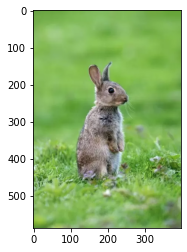

In [3]:
plt.imshow(im)

## Naive background subtraction with tophat filter

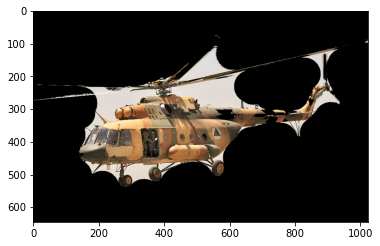

In [93]:
def subtract_background(image, radius=50, light_bg=False):        
        str_el =disk(radius) #you can also use 'ball' here to get a slightly smoother result at the cost of increased computing time
        if light_bg:
            return black_tophat(image, str_el)
        else:
            return white_tophat(image, str_el)

with Image.open('heli2.jpg') as pilim:    
    imrgb = np.asarray(pilim)
    if imrgb.shape[-1]==3:        
        np.concatenate((imrgb,np.zeros_like(imrgb[:,:,0])[:,:,np.newaxis]),axis=2)
im = color.rgb2gray(imrgb)
im2 = subtract_background(im,radius=50,light_bg=False)
# plt.imshow(im)
im_out = copy.deepcopy(imrgb)
for chan in range(im_out.shape[-1]):
    im_out[:,:,chan] = imrgb[:,:,chan]*(im2>0.1)
plt.imshow(im_out)

## Unsupervised image segmentation with Gaussian Mixture Model

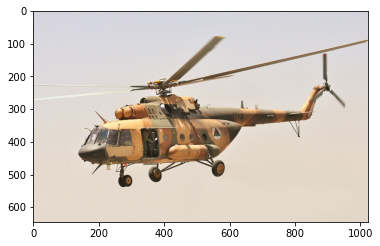

In [158]:
%matplotlib inline

img = io.imread('heli2.jpg')
img = np.concatenate((img,np.ones_like(img[:,:,0])[:,:,np.newaxis]*255),axis=2)
plt.imshow(img)

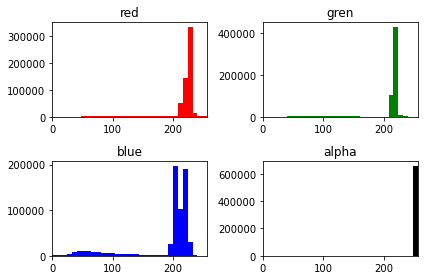

In [159]:
# image histogram
fig, ax = plt.subplots(2, 2)
cols = ['red','green','blue','black']
titles = ['red','gren','blue','alpha']
idces = np.meshgrid(np.arange(0,2),np.arange(0,2))
kk = np.arange(4)
for ii,jj,kk in zip(idces[1].ravel(),idces[0].ravel(),np.arange(4)):
    ax[ii,jj].hist(img[:,:,kk].ravel(), bins=32, range=[0, 256],color=cols[kk])   
    ax[ii,jj].set(xlim=(0, 256),title=titles[kk])
plt.tight_layout()

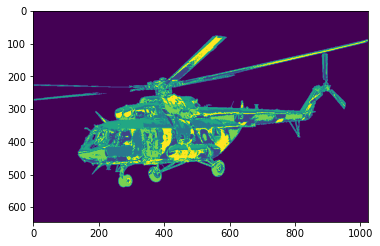

In [160]:
newdata = img.reshape(img.shape[0]*img.shape[1], 4)
gmm = GaussianMixture(n_components=6,covariance_type="spherical") # or 'tied'
gmm = gmm.fit(newdata)

cluster = gmm.predict(newdata)
cluster = cluster.reshape(img.shape[0], img.shape[1])
plt.imshow(cluster)

/home/timo/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  """Entry point for launching an IPython kernel.


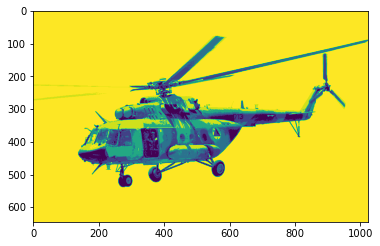

In [161]:
plt.imshow(color.rgb2gray(gmm.means_[cluster]))

In [162]:
cluster = gmm.predict(newdata)
# identify largest cluster (should be background, provided it's essentially monochrome)
largest_clust_id = np.argmax(np.bincount(cluster))
cluster = cluster.reshape(img.shape[0],img.shape[1])

In [163]:
img2 = copy.deepcopy(img)
for chan in range(4):
    img2[:,:,chan] = img[:,:,chan]*((cluster!=largest_clust_id))

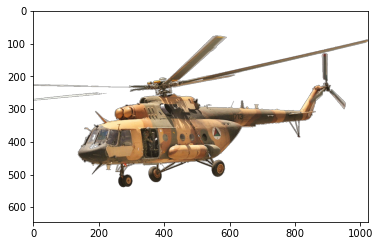

In [164]:
%matplotlib inline
plt.imshow(img2)